In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('clustering_R3.csv')
data.describe()

,X1,X2,X3
count,1000.000000,1000.000000,1000.000000
mean,240.181036,154.937365,5.454947
std,115.556334,41.964161,4.793973
min,38.516347,87.376621,0.125057
25%,148.801776,104.853322,1.806255
50%,231.754437,151.846118,3.430892
75%,350.277958,198.367658,8.287805
max,399.930758,213.917568,24.537806


Jak widać kolumna X3 ma znacznie mniejsze wartości niż X2 i X1. Żeby je trochę wyrównać użyjemy standaryzacji.

In [3]:
from sklearn import preprocessing
std = preprocessing.StandardScaler().fit(data)
data = pd.DataFrame(std.transform(data)).rename(columns={0: 'X1', 1: 'X2', 2: 'X3'})

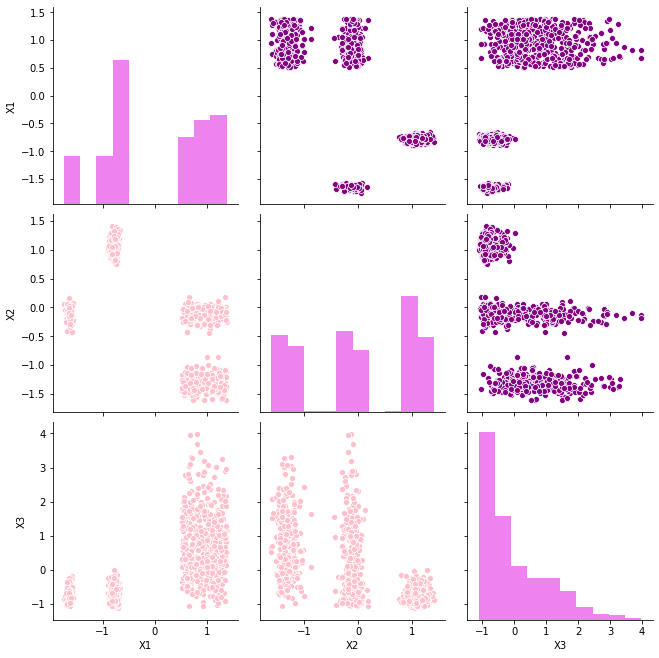

In [4]:
g = sns.PairGrid(data, height=3)
g.map_upper(sns.scatterplot,color='purple')
g.map_lower(sns.scatterplot, color='pink')
g.map_diag(plt.hist, color='violet')

# K-Średnich

Algorytm K-średnich polega na wstępnym podzieleniu populacji na z góry założoną liczbę skupień. Następnie uzyskany podział jest poprawiany w ten sposób, że niektóre elementy są przenoszone do innych klas, tak, aby uzyskać minimalną wariancję wewnątrz każdej z nich – dąży się do zapewnienia jak największego podobieństwa elementów w ramach każdego ze skupień, przy jednoczesnej maksymalnej różnicy pomiędzy samymi skupieniami. Każdy element przypisujemy do skupienia, do którego środka ma najbliżej. 

Do sprawdzenia optymalnej ilość klastrów użyjemy silhouette score (jak dobrze punkt pasuje do klastra, w którym się znajduje - im więcej tym lepiej) i davies bouldin score (miara podobieństwa klastra z najbardziej podobnym klastrem - im mniej tym lepiej).

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

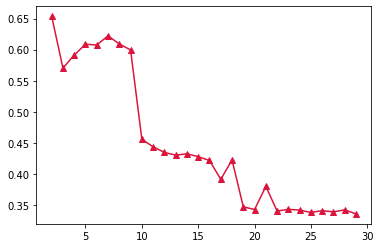

In [6]:
n = []
score = []

for n_clusters in range(2,30):
    clusterer = KMeans(n_clusters)
    preds = clusterer.fit_predict(data)
    n.append(n_clusters)
    score.append(silhouette_score(data, preds))
    
plt.plot(n,score,'^-', color="crimson")

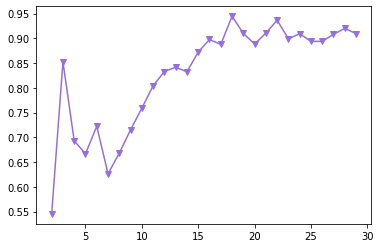

In [7]:
n = []
score = []

for n_clusters in range(2,30):
    clusterer = KMeans(n_clusters)
    preds = clusterer.fit_predict(data)
    n.append(n_clusters)
    score.append(davies_bouldin_score(data, preds))
    
plt.plot(n,score,'v-', color="mediumpurple")

Jak widać obie metryki zgadzają się że najlepsza ilość klastrów to 2.

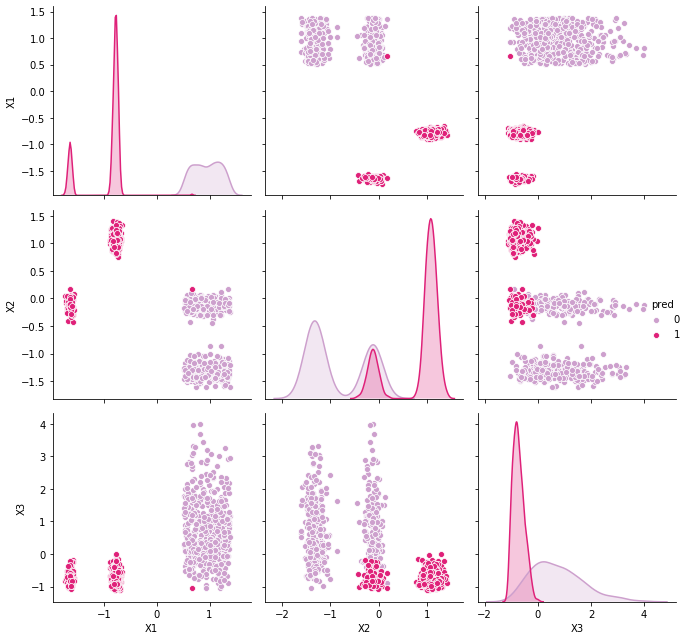

In [8]:
clusterer = KMeans(n_clusters=2)
clusterer.fit(data)
data['pred'] = clusterer.predict(data)

sns.pairplot(data, height=3, hue='pred', palette='PuRd')
plt.tight_layout()

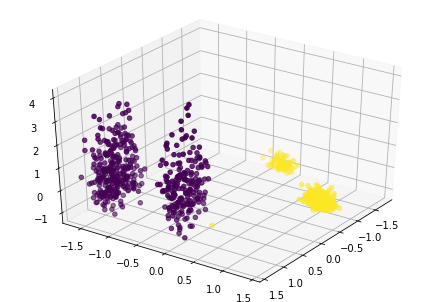

In [9]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

fig = pyplot.figure()
ax = Axes3D(fig)

ax.scatter(data.X1, data.X2, data.X3, c=data.pred)
ax.view_init(35, 35)

Faktycznie, ten podział wygląda na całkiem dobry, ale jednak na oko bardziej odpowiednie byłyby 4 klastry.

# DBSCAN

DBSCAN to algorytm nieparametrycznego klastrowania danych: biorąc pod uwagę zbiór punktów w pewnej przestrzeni, grupuje on punkty, które są blisko siebie upakowane (punkty z wieloma pobliskimi sąsiadami), oznaczając jako punkty skrajne punkty leżące samotnie w regionach o małej gęstości (których najbliżsi sąsiedzi są zbyt daleko). DBSCAN jest jednym z najczęstszych algorytmów klastrowania, a także najczęściej cytowanym w literaturze naukowej algorytmem.

In [10]:
from sklearn.cluster import DBSCAN
data2 = data.drop(columns=["pred"])

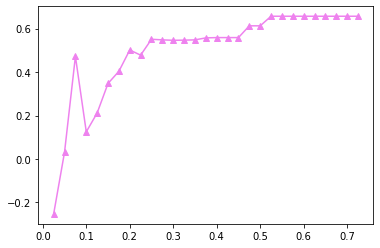

In [11]:
e = []
score = []

for eps in range(1,30):
    eps = eps/40
    clusterer = DBSCAN(eps)
    preds = clusterer.fit_predict(data2)
    e.append(eps)
    score.append(silhouette_score(data2, preds))
    
plt.plot(e,score,'^-', color="violet")

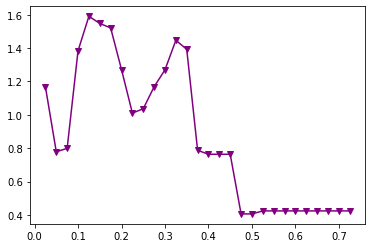

In [12]:
e = []
score = []

for eps in range(1,30):
    eps = eps/40
    clusterer = DBSCAN(eps)
    preds = clusterer.fit_predict(data2)
    e.append(eps)
    score.append(davies_bouldin_score(data2, preds))
    
plt.plot(e,score,'v-', color="purple")

Jak widać obie metryki wskazują na epsilon w okolicach wartości 0.55.

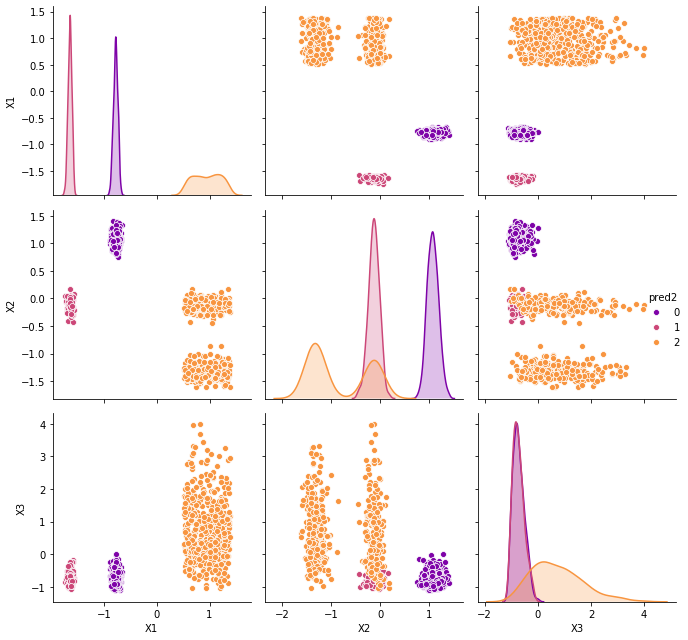

In [13]:
clusterer = DBSCAN(0.55)
data2['pred2'] = clusterer.fit_predict(data2.iloc[:,[0,1,2]])

sns.pairplot(data2, height=3, hue='pred2', palette='plasma')
plt.tight_layout()

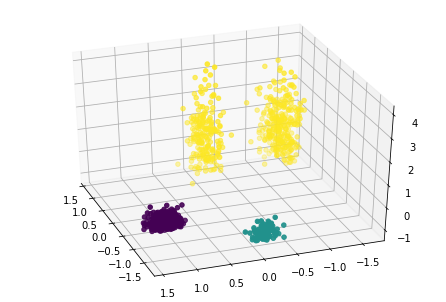

In [14]:
fig = pyplot.figure()
ax = Axes3D(fig)

ax.scatter(data2.X1, data2.X2, data2.X3, c=data2.pred2)
ax.view_init(35, 160)

Podział wygląda całkiem porządnie, na pierwszy rzut oka lepiej niż KMeans.

# Porównanie

In [15]:
preds1 = KMeans(2).fit_predict(data2.iloc[:,[0,1,2]])
preds2 = DBSCAN(0.55).fit_predict(data2.iloc[:,[0,1,2]])
a = silhouette_score(data2.iloc[:,[0,1,2]],preds1)
b = davies_bouldin_score(data2.iloc[:,[0,1,2]],preds1)
c = silhouette_score(data2.iloc[:,[0,1,2]],preds2)
d = davies_bouldin_score(data2.iloc[:,[0,1,2]],preds2)

print("KMeans: \nSilhouette score: {0}, \nDavies-Bouldin score: {1} \n\nDBSCAN: \nSilhouette score: {2}, \nDavies-Bouldin score: {3}".format(a, b, c, d))

KMeans: 
Silhouette score: 0.6538256076718254, 
Davies-Bouldin score: 0.5452007126116644 

DBSCAN: 
Silhouette score: 0.6571745269702408, 
Davies-Bouldin score: 0.42424560362901037


Jak widać powyżej DBSCAN ma trochę wyższy wynik Silhouette score a także lepszy (niższy) wynik Davies-Bouldin score. Powiedziałabym że to faktycznie DBSCAN poradził sobie tutaj trochę lepiej, chociaż nadal wydaje się że najlepszy podział tego datasetu nastąpiłby dla 4 klastrów, a nie 2 lub 3.